In [29]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import numpy as np
from sklearn import preprocessing

In [38]:
full_results = pd.read_csv('full_results.csv')
full_stats = pd.read_csv('FullKenPom_pt.csv')

print(full_results.shape)
print(full_stats.shape)

(1112, 11)
(1129, 27)


In [39]:
###mask test and train data###
res_test_mask = (full_results['Year'] == 2016) | (full_results['Year'] == 2017) | (full_results['Year'] == 2018)
stats_test_mask = (full_stats['Season'] == 2016) | (full_stats['Season'] == 2017) | (full_stats['Season'] == 2018)
res_train_mask = (full_results['Year'] < 2016)
stats_train_mask = (full_stats['Season'] < 2016)

res_data_test = full_results[res_test_mask]
stats_data_test = full_stats[stats_test_mask]
res_data_train = full_results[res_train_mask]
stats_data_train = full_stats[stats_train_mask]

#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

for i in range(len(res_data_test)):
    if res_data_test['Region Name'][i] == "First Four":
        res_data_test = res_data_test.drop(i)
for i in range(len(res_data_train)):
    if res_data_train['Region Name'][i] == "First Four":
        res_data_train = res_data_train.drop(i)
        
#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

res_data_train.head()

#res_data_test.tail()
#stats_data_test.tail()
#res_data_train.tail()
#stats_data_train.tail()


,level_0,index,Unnamed: 0,Year,Round,Region Number,Region Name,SeedA,ScoreA,TeamA,TeamB,ScoreB,SeedB
0,1,1,1,2002,1,1,South,1,84,Duke,Winthrop,37,16
1,2,2,2,2002,1,1,South,2,86,Alabama,Florida Atlantic,78,15
2,3,3,3,2002,1,1,South,3,71,Pittsburgh,Central Connecticut St,54,14
3,4,4,4,2002,1,1,South,4,89,USC,UNC Wilmington,93,13
4,5,5,5,2002,1,1,South,5,75,Indiana,Utah,56,12


In [40]:
#these names match the kenpom stats csv
stats_vec = ["AdjTempo",
            "AdjOE",
            "AdjDE",
            "AdjEM",
            "seed",
            "ConfTournament",
            "SOSAdjEM",
            "NCSOSAdjEM",
            "O-D_eFG_Pct",
            "D-O_TO_Pct",
            "O-D_OR_Pct",
            "O-D_FT_Rate",
            "LastTenRecord"]

print(len(stats_vec))

13


In [41]:
# Move training data into 2 numpy arrays - data and labels (results)
N = len(res_data_train)

training_data = np.zeros((N,13))
training_labels = np.zeros((N,1))

for i in range(len(res_data_train)):
    year = res_data_train['Year'][i]
    teamA = res_data_train['TeamA'][i]
    teamB = res_data_train['TeamB'][i]
    score_diff = res_data_train['ScoreA'][i] - res_data_train['ScoreB'][i]
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        training_data[i][s] = stats_data_train[stat][indexA] - stats_data_train[stat][indexB]
    
    if (score_diff > 0):
        training_labels[i][0] = 1
    else:
        training_labels[i][0] = 0


In [42]:
# Move testing data into 2 numpy arrays - data and labels (results)
N = len(res_data_test)

testing_data = np.zeros((N,13))
testing_labels = np.zeros((N,1))

for i in range(len(res_data_test)):
#for i in range(5):
    year = res_data_test['Year'][i]
    teamA = res_data_test['TeamA'][i]
    teamB = res_data_test['TeamB'][i]
    score_diff = res_data_test['ScoreA'][i] - res_data_test['ScoreB'][i]
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        testing_data[i][s] = stats_data_test[stat][indexA] - stats_data_test[stat][indexB]
    
    if (score_diff > 0):
        testing_labels[i][0] = 1
    else:
        testing_labels[i][0] = 0


In [43]:
print(training_data.shape)
print(training_labels.shape)
print('\n')
print(testing_data.shape)
print(testing_labels.shape)

(882, 13)
(882, 1)


(189, 13)
(189, 1)


In [44]:
#Time to normalize the data
training_data = preprocessing.normalize(training_data, axis=0, norm='max')
testing_data = preprocessing.normalize(testing_data, axis=0, norm='max')


In [45]:
dtrain = xgb.DMatrix(training_data, label=training_labels,
                     feature_names=stats_vec)
dtest = xgb.DMatrix(testing_data, label=testing_labels,
                    feature_names=stats_vec)


In [46]:
param = {}
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 500 #looks like it levels off at around 200
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:0.456501	train-rmse:0.42786
[1]	eval-rmse:0.444732	train-rmse:0.381052
[2]	eval-rmse:0.440124	train-rmse:0.352045
[3]	eval-rmse:0.437681	train-rmse:0.319463
[4]	eval-rmse:0.438402	train-rmse:0.291606
[5]	eval-rmse:0.440746	train-rmse:0.277335
[6]	eval-rmse:0.442821	train-rmse:0.2616
[7]	eval-rmse:0.443371	train-rmse:0.25638
[8]	eval-rmse:0.444118	train-rmse:0.249788
[9]	eval-rmse:0.442416	train-rmse:0.24255
[10]	eval-rmse:0.446831	train-rmse:0.237158
[11]	eval-rmse:0.447174	train-rmse:0.230813
[12]	eval-rmse:0.446807	train-rmse:0.215077
[13]	eval-rmse:0.449625	train-rmse:0.206722
[14]	eval-rmse:0.449103	train-rmse:0.196245
[15]	eval-rmse:0.446524	train-rmse:0.185703
[16]	eval-rmse:0.447204	train-rmse:0.177377
[17]	eval-rmse:0.449239	train-rmse:0.174198
[18]	eval-rmse:0.447624	train-rmse:0.171837
[19]	eval-rmse:0.446831	train-rmse:0.166534
[20]	eval-rmse:0.447831	train-rmse:0.160681
[21]	eval-rmse:0.449486	train-rmse:0.154482
[22]	eval-rmse:0.450102	train-rmse:0.143446
[23

[186]	eval-rmse:0.450945	train-rmse:0.001023
[187]	eval-rmse:0.450945	train-rmse:0.001023
[188]	eval-rmse:0.450945	train-rmse:0.001023
[189]	eval-rmse:0.450945	train-rmse:0.001023
[190]	eval-rmse:0.450945	train-rmse:0.001023
[191]	eval-rmse:0.450945	train-rmse:0.001023
[192]	eval-rmse:0.450945	train-rmse:0.001023
[193]	eval-rmse:0.450945	train-rmse:0.001023
[194]	eval-rmse:0.450945	train-rmse:0.001023
[195]	eval-rmse:0.450945	train-rmse:0.001023
[196]	eval-rmse:0.450945	train-rmse:0.001023
[197]	eval-rmse:0.450945	train-rmse:0.001023
[198]	eval-rmse:0.450945	train-rmse:0.001023
[199]	eval-rmse:0.450945	train-rmse:0.001023
[200]	eval-rmse:0.450945	train-rmse:0.001023
[201]	eval-rmse:0.450945	train-rmse:0.001023
[202]	eval-rmse:0.450945	train-rmse:0.001023
[203]	eval-rmse:0.450945	train-rmse:0.001023
[204]	eval-rmse:0.450945	train-rmse:0.001023
[205]	eval-rmse:0.450945	train-rmse:0.001023
[206]	eval-rmse:0.450945	train-rmse:0.001023
[207]	eval-rmse:0.450945	train-rmse:0.001023
[208]	eval

[369]	eval-rmse:0.450945	train-rmse:0.001023
[370]	eval-rmse:0.450945	train-rmse:0.001023
[371]	eval-rmse:0.450945	train-rmse:0.001023
[372]	eval-rmse:0.450945	train-rmse:0.001023
[373]	eval-rmse:0.450945	train-rmse:0.001023
[374]	eval-rmse:0.450945	train-rmse:0.001023
[375]	eval-rmse:0.450945	train-rmse:0.001023
[376]	eval-rmse:0.450945	train-rmse:0.001023
[377]	eval-rmse:0.450945	train-rmse:0.001023
[378]	eval-rmse:0.450945	train-rmse:0.001023
[379]	eval-rmse:0.450945	train-rmse:0.001023
[380]	eval-rmse:0.450945	train-rmse:0.001023
[381]	eval-rmse:0.450945	train-rmse:0.001023
[382]	eval-rmse:0.450945	train-rmse:0.001023
[383]	eval-rmse:0.450945	train-rmse:0.001023
[384]	eval-rmse:0.450945	train-rmse:0.001023
[385]	eval-rmse:0.450945	train-rmse:0.001023
[386]	eval-rmse:0.450945	train-rmse:0.001023
[387]	eval-rmse:0.450945	train-rmse:0.001023
[388]	eval-rmse:0.450945	train-rmse:0.001023
[389]	eval-rmse:0.450945	train-rmse:0.001023
[390]	eval-rmse:0.450945	train-rmse:0.001023
[391]	eval

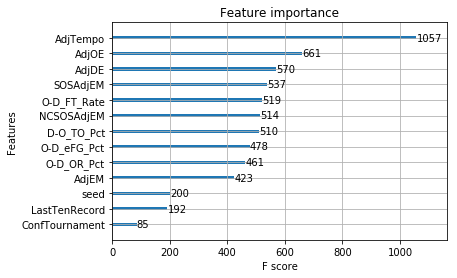

In [47]:
xgb.plot_importance(bst)

In [48]:
ypred = bst.predict(dtest)

In [52]:
print(ypred.shape)
print(testing_labels.shape)

(189,)
(189, 1)
